# The Drum Part Classification Model for the Environmental Drum Machine main kit

This notebook hosts the code used to develop, train and evaluate the Drum Part Classification Model. This model is then used to classify environmental sounds into their "closer" drum part, taking a set of low-level features as refeerence.


### Preparing the environment

Mounting Google Drive file access.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Essentia (for sound processing and feature extraction).

In [2]:
#If not installed, install Essentia and mirdata
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

     |████████████████████████████████| 12.0MB 5.0MB/s 


In [3]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np
import json
import tqdm

### Loading util functions to process the Freesound dataset.

Loading the necessary functions to load and filter the Freesound One-Shot Percussive Sounds Dataset.

In [4]:
def load_dataset(dataset_path):
    licenses_file = ""
    dataset_dict = {}
    for element in os.listdir(dataset_path):
        if '.txt' in element:
            licenses_file = os.path.join(dataset_path, element)
        if 'analysis' in element:
            for sub_folder in os.listdir(os.path.join(dataset_path, element)):
                if 'DS_' not in sub_folder:
                    for analysis_file in os.listdir(os.path.join(dataset_path, element, sub_folder)):
                        if 'DS_' not in analysis_file:

                            track_id = analysis_file.replace("_analysis.json", "")
                            audio_file = track_id + '.wav'

                            dataset_dict[track_id] = {
                                'audio_path': os.path.join(
                                    dataset_path, 'one_shot_percussive_sounds', sub_folder, audio_file
                                ),
                                'analysis_path': os.path.join(
                                    dataset_path, 'one_shot_percussive_sounds', sub_folder, analysis_file
                                )
                            }

    with open(licenses_file, 'r') as fhandle:
        sounds_dict = json.load(fhandle)

    drum_part_dict = {
        'kick_sounds': [],
        'snare_sounds': [],
        'hi_hat_sounds': []
    }
    
    for i in sounds_dict.items():
        if 'kick' in i[1]['name'].lower():
            drum_part_dict['kick_sounds'].append(i[0])
        if 'snare' in i[1]['name'].lower():
            drum_part_dict['snare_sounds'].append(i[0])
        if 'hat' in i[1]['name'].lower():
            drum_part_dict['hi_hat_sounds'].append(i[0])

    return dataset_dict, drum_part_dict

In [5]:
def filter_dataset(dataset_dict, drum_part_dict):
    dataset = {
        'kick': [],
        'snare': [],
        'hi-hat': []
    }
    for track in dataset_dict.items():
        if track[0] in drum_part_dict['kick_sounds']:
            dataset['kick'].append(track[1]['audio_path'])
        if track[0] in drum_part_dict['snare_sounds']:
            dataset['snare'].append(track[1]['audio_path'])
        if track[0] in drum_part_dict['hi_hat_sounds']:
            dataset['hi-hat'].append(track[1]['audio_path'])

    return dataset

### Load, filter, format and extract features from the dataset

Let's now load and filter the dataset.

In [6]:
dataset_dict, drum_part_dict = load_dataset(
    '/content/drive/MyDrive/000-MASTER/TRIM2/Computational Music Creativity/Freesound One-Shot Percussion Dataset'
)

dataset = filter_dataset(dataset_dict, drum_part_dict)

We can create a formatted version of the dataset, re-arranging the names and structure of the data. That will adapt better to the code we are re-using for this task.

In [7]:
# Let's use the location of the dataset to store the new segments
main_data_dir = '/content/'
fs = 44100
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir):  #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for label, files in tqdm.tqdm(dataset.items()):
    for sample_file in files:
        track_id = sample_file.split("/")[-1].replace(".wav", "")
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()

        #Amplitude normalisation
        x = x / np.max(np.abs(x))
        filename = os.path.join(segments_dir, track_id + '_' + label + '.wav')
        ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x)
        segment_files.append(filename)

print(len(segment_files),'segment files created')

100%|██████████| 3/3 [19:37<00:00, 392.54s/it]

2884 segment files created


In [ ]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

Load the Essentia's MusicExtractor to obtain the features.

In [8]:
import essentia.standard as ess

#Running music extractor for a file:
file = segment_files[0] #simply pick the first file in the list
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

Listing the used features here.

In [9]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [10]:
segment_files = []
for i in os.listdir('/content/segments'):
    segment_files.append(
        os.path.join('/content/segments', i)
    )

Extracting features of the formatted samples, and storing them in a temporary .csv file.

In [25]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = '/content/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors).replace('lowlevel.','') + ',' + 'label' + '\n'
    writer.write(line2write)
    for filename in tqdm.tqdm(segment_files):
        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                    lowlevelFrameSize = 2048,
                                                    lowlevelHopSize = 1024,
                                                    lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        line2write = str(selected_features)[1:-1] + ',' + filename.split("_")[1].replace(".wav", "") + '\n'
        writer.write(line2write)

100%|██████████| 2884/2884 [09:06<00:00,  5.28it/s]


### Preprocessing the feature file

Let's now move to the Machine Learning part of the experiment. We load the .csv file with the features, pre-process them and train/evaluate the models with that.

In [26]:
import pandas as pd

In [27]:
#Read data
data_file = '/content/data.csv'
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,label
0,0.990684,12.399338,2.942449,0.268756,0.052943,4.527077,7.071927,-1.911153,1.259597,29.539131,19.316700,0.434776,0.145623,0.000000,16.344131,3.864924,0.303949,0.044545,6.549275,4.921467,-2.384682,0.640717,25.944630,14.455625,54.937565,75.877251,-23.741116,0.0,-23.741116,0.000000,-32.491730,0.0,11.612022,3.595969,0.186292,0.025076,-0.221627,1.640074,-0.111021,1.158222,...,0.0,1.000000,0.00000,0.555556,0.496904,4448.559570,1258.513550,6.333333,8.178562,-1.430299e-09,1.932036e-09,0.010381,0.014168,0.008053,0.011177,0.000002,0.000004,0.001987,0.002755,0.000342,0.000381,7.851759,0.720981,0.064467,0.060808,0.728389,1.744962,0.002190,0.002309,6383.398438,360.192291,0.118397,0.288006,7113373.0,9961418.00,6.293334,9.223127,0.204590,0.055020,hi-hat
1,0.990684,18.642298,6.679070,0.570366,0.196535,284.729767,535.328125,3.909230,6.302772,4.514034,12.678677,0.450436,0.027449,0.000000,20.518570,8.182852,0.337891,0.103591,169.306381,121.768326,8.970623,5.145808,15.625275,23.671623,8.116062,15.877343,-17.420408,0.0,-17.420408,0.000000,-26.171021,0.0,26.838743,8.517510,0.693562,0.225892,57.856400,64.261940,3.125789,2.955288,...,0.0,0.909091,0.28748,0.272727,0.445362,386.213013,696.200989,2.454545,5.105498,-8.451648e-09,1.036589e-08,0.032635,0.039707,0.000561,0.001704,0.025114,0.031993,0.000789,0.002459,0.008066,0.019463,5.108780,1.833912,0.113069,0.099747,28.116070,23.290754,0.004411,0.003519,395.427917,951.601501,3.829312,2.279202,6361009.5,10756363.00,0.252174,0.215590,0.006880,0.007594,kick
2,0.990684,20.174097,5.128329,0.237165,0.080763,23.601564,39.531441,3.986633,2.810240,19.415859,10.709785,0.407533,0.166521,24.158119,8.945119,3.566087,0.159399,0.092319,-0.437988,1.175397,-0.278657,0.886438,67.941025,19.950727,2.471807,5.845834,-14.890029,0.0,-45.485249,25.716602,-23.640154,0.0,25.347460,8.602598,0.260855,0.079989,57.238041,67.594887,6.176138,3.643318,...,0.0,1.000000,0.00000,0.793103,0.405081,1171.450317,404.023041,1.379310,3.623808,-1.207744e-09,3.102991e-09,0.004783,0.012230,0.000135,0.000313,0.000021,0.000085,0.000232,0.000607,0.004416,0.011487,7.53002

In [28]:
data_modif = data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [29]:
data_modif.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.mean,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,2884.0,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.0,2884.000000,2884.000000,2884.000000,2884.0,2884.000000,2884.000000,2884.000000,2884.000000,2.884000e+03,2.884000e+03,2884.000000,2884.000000,...,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000,2884.000000
mean,0.0,0.507960,0.394906,0.358243,0.283154,0.013058,0.015514,0.154532,0.053575,0.195040,0.183045,0.828994,0.226753,0.131464,0.351448,0.326988,0.308864,0.213156,0.107139,0.109771,0.446134,0.239904,0.276003,0.260086,0.033337,0.050591,0.539732,0.0,0.707653,0.104181,0.542650,0.0,0.472640,0.334032,0.396745,0.253824,3.575549e-04,3.528193e-04,0.005818,0.001063,...,0.973790,0.082886,0.915158,0.254726,0.590549,0.871573,0.217401,0.138349,0.117975,0.313934,0.971564,0.040166,0.029175,0.040270,0.022862,0.035575,0.032168,0.047085,0.020650,0.033527,0.139357,0.225346,0.683902,0.232569,0.112010,0.175238,0.053328,0.042031,0.105746,0.119490,0.190608,0.113250,0.163273,0.136425,0.216490,0.235527,0.017060,0.033083,0.199814,0.203240
std,0.0,0.240366,0.161763,0.248571,0.199438,0.054631,0.062531,0.074919,0.083064,0.193355,0.154088,0.148116,0.198894,0.185140,0.222118,0.177132,0.154496,0.155555,0.197100,0.186959,0.165430,0.220078,0.191616,0.151362,0.060840,0.081481,0.144822,0.0,0.162614,0.157412,0.142965,0.0,0.237277,0.152073,0.276582,0.181668,1.862116e-02,1.862103e-02,0.020265,0.018825,...,0.092415,0.237009,0.15989

In [30]:
data_modif.label.value_counts()

snare     1359
kick      1034
hi-hat     491
Name: label, dtype: int64

The data is a bit unbalanced, so we must take care in the evaluation.

### Training an evaluating the automatic classifier

First, we need to prepare the data arrays for features (inputs, X) and labels (outputs, y)

Now, we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [36]:
#input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 

#Creating output values
data_modif.label = pd.Categorical(data_modif.label) #convert to categorical data
y = np.array(data_modif.label.cat.codes) #create label encoded outputs

Splitting data into train and test subsets.

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit

num_folds = 10
sss = StratifiedShuffleSplit(n_splits = num_folds, test_size = 0.33, random_state = 42)
sss.get_n_splits(X, y)

10

The following cell contains the pipeline for training and testing using every generated train/test stratified split. The obtained metrics for every iteration are stored in lists and then the average is computed.

In [38]:
#Define and train the model
from sklearn import svm
from sklearn.metrics import recall_score, precision_score

accuracy_list = []
precision_list = []
recall_list = []

for train_index, test_index in sss.split(X, y):
    # Generate the splits of the actual fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the model with a relevant gamma value
    clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

    # Fit the model
    clf.fit(X_train, y_train)

    # Run the model over the testing samples
    y_pred = clf.predict(X_test)

    # Compute accuracy, precision and recall metrics and store the result in a list
    accuracy_list.append(np.sum(y_test == y_pred)/len(y_test))
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))

print('<-- Average metrics after {} folds -->'.format(num_folds))
print('Accuracy:', np.sum(np.array(accuracy_list))/num_folds)
print('Precision:', np.sum(np.array(precision_list))/num_folds)
print('Recall:', np.sum(np.array(recall_list))/num_folds)

<-- Average metrics after 10 folds -->
Accuracy: 0.9227941176470589
Precision: 0.9255538765933691
Recall: 0.9227941176470589


We can also consider a more detailed classification report, analyzing how the precision and recall values look like for every particular drum part class. For that, we will take the last iteration of the 10 folds and print out the detailed report. We can assume that the rest of the folds will follow the similar trend.



In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       162
           1       0.97      0.95      0.96       341
           2       0.88      0.96      0.92       449

    accuracy                           0.92       952
   macro avg       0.92      0.88      0.89       952
weighted avg       0.92      0.92      0.91       952



As the final step, let's also print the **confusion matrix**

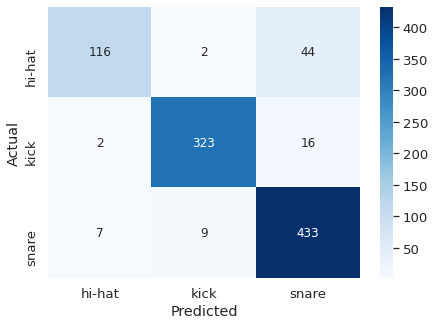

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.label)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt=".0f");

**FROM HERE WE INFER THAT FOR THE CODE, hi-hat = 0, kick = 1, and snare = 2.** This information is required when classifying the environmental sounds.

Let's now apply a feature selection process to remove unnecessary features keeping just the most relevant ones for the problem we are considering.

Optimal number of features : 64


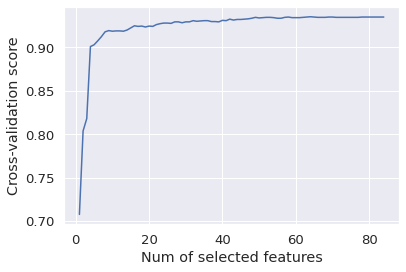

In [42]:
# ¡¡¡  Code outline based on sklearn documentation !!!
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# Create the SVC with a linear kernel
svc = SVC(kernel="linear")
#decision_tree = DecisionTreeClassifier()

# Run the RFE in 10-fold cross validation and get model results
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10), scoring='accuracy', min_features_to_select=1)
rfecv.fit(X, y)

# Print optimal number of features to achieve the best result
print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Num of selected features")
plt.ylabel("Cross-validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

We remove the feature columns from the data matrix which
have been identified as not relevant by our model. Within this set of irrelevant features, we would find the ones with variance 0 over samples, and the ones that cannot explain our data at all.

In [43]:
X_opt = X.copy()
for indx, i in reversed(list(enumerate(rfecv.support_))):
    if i == False:
        X_opt = np.delete(X_opt, indx, 1)

Let's define and generate the Stratified splits for the experiments, now using the optimized feature matrix.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

num_folds = 10
sss = StratifiedShuffleSplit(n_splits = num_folds, test_size = 0.33, random_state =42)
sss.get_n_splits(X_opt, y)

10

We run the pipeline with the optimized feature matrix splits.

In [45]:
#Define and train the model
from sklearn import svm
from sklearn.metrics import recall_score, precision_score

accuracy_list = []
precision_list = []
recall_list = []

for train_index, test_index in sss.split(X_opt, y):
    # Generate the splits of the actual fold
    X_train, X_test = X_opt[train_index], X_opt[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the model with a relevant gamma value
    clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

    # Fit the model
    clf.fit(X_train, y_train)

    # Run the model over the testing samples
    y_pred = clf.predict(X_test)

    # Compute accuracy, precision and recall metrics and store the result in a list
    accuracy_list.append(np.sum(y_test == y_pred)/len(y_test))
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))

print('<-- Average metrics after {} folds -->'.format(num_folds))
print('Accuracy:', np.sum(np.array(accuracy_list))/num_folds)
print('Precision:', np.sum(np.array(precision_list))/num_folds)
print('Recall:', np.sum(np.array(recall_list))/num_folds)

<-- Average metrics after 10 folds -->
Accuracy: 0.9279411764705883
Precision: 0.9298896155731521
Recall: 0.9279411764705883


**NOW WE HAVE OUR CLASSIFIER CLF!**

### Processing environmental sounds

This section assumess that a list of interesting environmental sounds has been selected and downloaded.

In [46]:
import os
import IPython
from scipy.io.wavfile import write

example_audio_path = '/content/environmental_sound.wav'
IPython.display.Audio(example_audio_path)

Removing the unvoiced regions with an energy threshold. This will help also to achieve a better flow when playing the drum patterns.

In [53]:
# Raw-data preprocess analysis parameters
fs = 44100
windowSize = 2048
hopSize = 256
NRG_threshold_ratio = 0.001 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":44100, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [54]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

We can plot the results of the splitting function and generate a new processed audio.

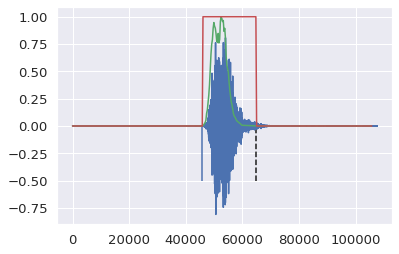

In [61]:
plt.figure()
(x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(example_audio_path, params)
#Plotting functions for checking the split decisions
plt.plot(x, label = 'sound waveform')
plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')
plt.show()

processed_filename = "/content/processed_environmental_sound.wav"
with open(processed_filename, 'w'):
    write(processed_filename, 44100, x[start_indexes[0]:stop_indexes[-1]])

IPython.display.Audio(processed_filename)

### Classify the sound using the trained model

Let's now extract and keep the relevant features from this sample.

In [67]:
features, features_frames = ess.MusicExtractor(
    lowlevelSilentFrames='drop',
    lowlevelFrameSize = 2048,
    lowlevelHopSize = 1024,
    lowlevelStats = ['mean', 'stdev'])(processed_filename)

selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]

In [75]:
X_sound = []
for i, relevant in zip(selected_features, rfecv.support_):
    if relevant:
        X_sound.append(i)
X_sound = np.array(X_sound)

Run the classifier on the sample.

In [77]:
y_pred = clf.predict(X_sound.reshape(1, -1))

In [78]:
y_pred

array([2], dtype=int8)

**As early mentioned, since we have a 2 here, it means that this sound is classified as a SNARE.**